In [1]:
import pandas as pd
import numpy as np
from prepare_regression import *
from algo import *
from plotter import *
import warnings; warnings.simplefilter('ignore')
import requests as requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic

In [72]:
data = pd.read_csv('data/30_terror_en.csv', parse_dates=['date'], index_col=0)

In [73]:
data

,date,article,language,pageviews
0,2012-01-01,abu_sayyaf,en,254
1,2012-01-02,abu_sayyaf,en,351
2,2012-01-03,abu_sayyaf,en,423
3,2012-01-04,abu_sayyaf,en,418
4,2012-01-05,abu_sayyaf,en,804
...,...,...,...,...
43825,2014-12-27,dirty_bomb,en,205
43826,2014-12-28,dirty_bomb,en,210
43827,2014-12-29,dirty_bomb,en,259
43828,2014-12-30,dirty_bomb,en,312


In [74]:
#data = data[data.article != 'hamas']

In [75]:
relevant= prepare_data_for_regression_with_window(data, 1,48,18)

In [76]:
relevant

,date,pageviews,time,intervention,post_slope
0,2012-01-31,723019,1,0,0
1,2012-02-29,716991,2,0,0
2,2012-03-31,735884,3,0,0
3,2012-04-30,678108,4,0,0
4,2012-05-31,819214,5,0,0
5,2012-06-30,623952,6,0,0
6,2012-07-31,628146,7,0,0
7,2012-08-31,672838,8,0,0
8,2012-09-30,919039,9,0,0
9,2012-10-31,1059694,10,0,0


                            OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.555
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     18.26
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           7.63e-08
Time:                        21:33:51   Log-Likelihood:                -647.92
No. Observations:                  48   AIC:                             1304.
Df Residuals:                      44   BIC:                             1311.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             5.404e+05 

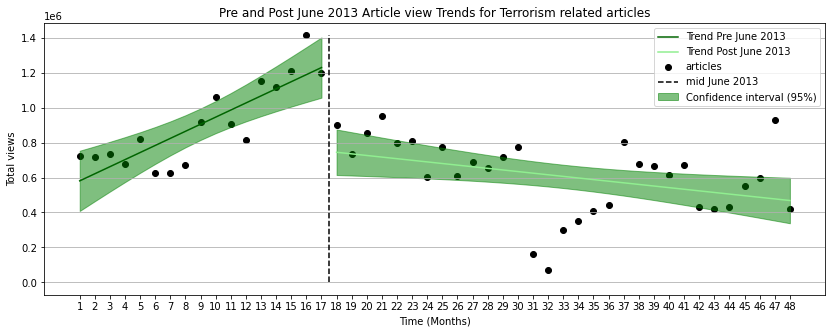

In [77]:
plotter(relevant, graph_title="Pre and Post June 2013 Article view Trends for Terrorism related articles")
plt.savefig("terror_articles.png")

## Remarks: 
Taking an extended version of the data, we are confronted to the challenge of new confounders i.e events that may change the online behavior towards the terrorism related articles. 
We spotted a remarkable drop in the views in July 2014. We would like to test the importance of this drop statistically and whether it was due to a behavior-changing event or just these points were outliers. 
We first notice that, in our dataset, in months July and August 2014, there are a lot of articles with zero pageviews.

After fitting a segmented regression model with intervention on June 2014, we see that the pvalue of the intervention is small (0.02) and less than 0.05. On the other hand, the pvalues of the month index and post slope parameters are high ...
Also, the R square value of the model is 0.415, which means that the segmented regression with the intervention set 

In [ ]:
##algorithm

confounder_founder(data, 12, 5)

In [ ]:


def get_pageview_data(articles, years, lang, save_csv=True):
    search_url = f'http://petermeissner.de:8880/article/exact/{lang}/'
    final_list = []
    
    for article in articles:
        article_no_spaces = re.sub(r'\s','_', article)
        request = requests.get(search_url + article_no_spaces).json()
        if request['status'] != 'ok':
            print(f'Problem fetching data for article {article}')
            continue
        data = request['data']
        for elem in data:
            year = elem['year']
            if str(year) in years:
                timestamps = pd.date_range(f'01-01-{year}', f'31-12-{year}')
                page_views = elem['page_view_count'].split(',')
                assert len(timestamps) == len(page_views)
                final_list += list(zip(timestamps, [article] * len(timestamps), [lang] * len(timestamps), page_views)) 
    df = pd.DataFrame(final_list, columns=['date', 'article','language', 'pageviews'])
    if save_csv:
        df.to_csv(f'data/data_{lang}.csv')
    return df

In [ ]:
domestic= ["Department_of_Homeland_Security", "Federal_Emergency_Management_Agency", "Coast_Guard", "Customs_and_Border_Protection"
    ,   "Border_patrol", "Secret_Service", "Bureau_of_Land_Management", "Homeland_defense", "Espionage", "Task_Force_88","Central_Intelligence_Agency",
     "Fusion_center", "DEA", "Secure_Border_Initiative", "Federal_Bureau_of_Investigation", "Alcohol_and_Tobacco_Tax_and_Trade_Bureau", "U.S._Citizenship_and_Immigration_Services",
    "Federal_Air_Marshal_Service","Transportation_Security_Administration", "Air_Marshal", "Federal_Aviation_Administration", "National_Guard", "Emergency_Management", 
    "U.S._Immigration_and_Customs_Enforcement", "United_Nations"]
     
     
     
     
     
     
     

In [ ]:
domestic_articles = get_pageview_data(domestic, ['2012', '2013','2014','2015'], 'en')

In [ ]:
domestic_articles.to_csv(f'data/domestic_en.csv')

In [ ]:
len(domestic_articles.groupby("article").sum())

In [64]:
relevant=pd.read_csv("data/domestic_en.csv", parse_dates=['date'], index_col=0)

## Extension of comparator group : domestic security articles

In [65]:
relevant

,date,article,language,pageviews
0,2012-01-01,Department_of_Homeland_Security,en,170
1,2012-01-02,Department_of_Homeland_Security,en,181
2,2012-01-03,Department_of_Homeland_Security,en,234
3,2012-01-04,Department_of_Homeland_Security,en,243
4,2012-01-05,Department_of_Homeland_Security,en,261
...,...,...,...,...
36520,2014-12-27,United_Nations,en,4414
36521,2014-12-28,United_Nations,en,4519
36522,2014-12-29,United_Nations,en,5360
36523,2014-12-30,United_Nations,en,0


In [66]:
relevant= relevant[relevant.article != "Federal_Bureau_of_Investigation" ]

In [67]:
relevant= relevant[relevant.article!= "United_Nations" ]

In [68]:
len(relevant.groupby('article').sum())

23

In [69]:
relevant= prepare_data_for_regression_with_window(relevant, 1,48, 18)

In [70]:
relevant

,date,pageviews,time,intervention,post_slope
0,2012-01-31,430628,1,0,0
1,2012-02-29,392609,2,0,0
2,2012-03-31,387834,3,0,0
3,2012-04-30,367790,4,0,0
4,2012-05-31,371885,5,0,0
5,2012-06-30,340542,6,0,0
6,2012-07-31,311307,7,0,0
7,2012-08-31,356671,8,0,0
8,2012-09-30,354756,9,0,0
9,2012-10-31,458993,10,0,0


                            OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     20.46
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.89e-08
Time:                        21:33:26   Log-Likelihood:                -604.59
No. Observations:                  48   AIC:                             1217.
Df Residuals:                      44   BIC:                             1225.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             3.621e+05 

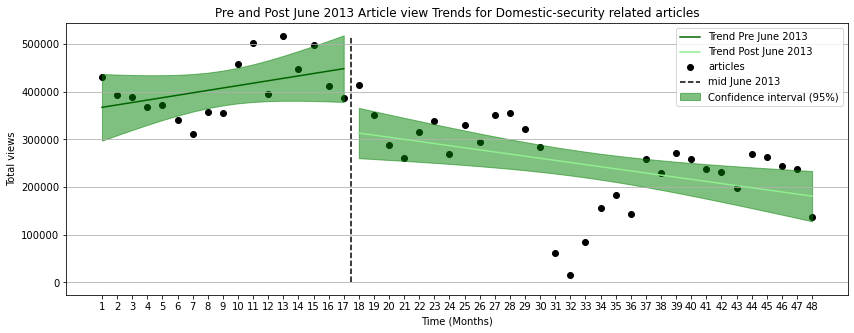

In [71]:
plotter(relevant, graph_title="Pre and Post June 2013 Article view Trends for Domestic-security related articles")
plt.savefig("domestic_extended.jpg")

## extension of comparator group: infrastructure articles


In [6]:
#infra=["Information_security", "Airport", "Airplane", "Chemical_burn", "CIKR", "AMTRAK", "Collapse",
#      "Information_infrastructure", "Telecommunications_Network", "Telecommunication", "Critical_infrastructure",
#      "National_Information_Infrastructure", "Metro", "Subway", "Washington_Metropolitan_Area_Transit_Authority", "Metropolitan_Atlanta_Rapid_Transit_Authority",
#    "Port_Authority", "NBIC", "Electrical_grid", "Power", "Smart", "Full_body_scanner", "Electric_power",
#      "Failure", "Power_outage", "Blackout", "Brownout", "Port", "Dock_(maritime)", "Bridge", "Flight_cancellation_and_delay", 
#        "Delay", "Electric_power_transmission"]

In [7]:
#infra_articles = get_pageview_data(infra, ['2012', '2013','2014','2015'], 'en')

In [8]:
#infra_articles.to_csv(f'data/infra_en.csv')

In [9]:
#infra_articles=infra_articles.drop(columns="language")

In [10]:
relevant_articles = pd.read_csv("data/infra_en.csv", parse_dates=['date'], index_col=0)

In [11]:
relevant_articles

,date,article,language,pageviews
0,2012-01-01,Information_security,en,655
1,2012-01-02,Information_security,en,1232
2,2012-01-03,Information_security,en,1857
3,2012-01-04,Information_security,en,1884
4,2012-01-05,Information_security,en,2121
...,...,...,...,...
48208,2014-12-27,Electric_power_transmission,en,765
48209,2014-12-28,Electric_power_transmission,en,705
48210,2014-12-29,Electric_power_transmission,en,1038
48211,2014-12-30,Electric_power_transmission,en,1012


In [12]:
relevant_articles= prepare_data_for_regression_with_window(relevant_articles, 1,48, 18)

In [13]:
relevant_articles

,date,pageviews,time,intervention,post_slope
0,2012-01-31,992559,1,0,0
1,2012-02-29,835766,2,0,0
2,2012-03-31,868425,3,0,0
3,2012-04-30,799103,4,0,0
4,2012-05-31,846491,5,0,0
5,2012-06-30,667375,6,0,0
6,2012-07-31,607016,7,0,0
7,2012-08-31,618165,8,0,0
8,2012-09-30,640390,9,0,0
9,2012-10-31,758095,10,0,0


                            OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.552
Method:                 Least Squares   F-statistic:                     20.31
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           2.06e-08
Time:                        19:46:07   Log-Likelihood:                -640.30
No. Observations:                  48   AIC:                             1289.
Df Residuals:                      44   BIC:                             1296.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             8.091e+05 

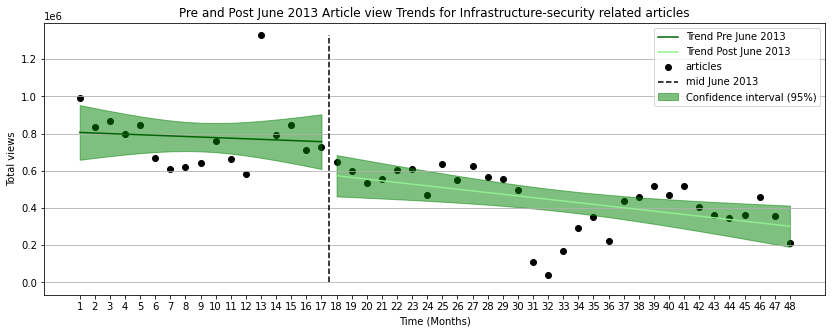

In [14]:
plotter(relevant_articles, graph_title="Pre and Post June 2013 Article view Trends for Infrastructure-security related articles")
plt.savefig("infrastructure_extended")